<a href="https://colab.research.google.com/github/Marsobad/ADL/blob/master/TP4_active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning Practical

Active Learning is generally useful in a specific case of small data: when unlabelled data is plentiful, but labelling it is costly. Think for example that each example must be analysed by an expert for labelling it. Expert time is costly, so we would like to be able to train a successful classifier while labelling as few examples as possible.

Active Learning is an approach to answer this problem. The general principle is the following: we first randomly ask the expert to label a small random subset of the training data, and train our classifier on it. Once this first step is done, we can analyse the behaviour of our trained model on the yet unlabelled data, to deduce which additional examples would be worth labelling to improve the quality of the model as quickly as possible. We then retrain the model on the new larger labelled dataset and iterate this process, labelling more and more examples, until we reach a satisfying performance. And hopefully reaching it while only labelling a small fraction of the whole available dataset.

The main question in Active Learning is thus the following: How should we choose the next batch of examples to be labelled?

There are different strategies for this, that you will compare in this practical.

### Example setup

We will emulate an active learning situation using the MNIST dataset, starting by pretending we don't have the labels. The "ask an expert to label the example" step will thus be simply picking the label from the dataset.

You'll have to provide a neural network architecture and the implementation of various active learning strategies, with the goal of comparing them. Keep in mind that the start of the training will be on very small datasets when designing your architectures.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from heapq import nsmallest
import numpy as np
import random

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Loading MNIST dataset from torchvision.dataset
original_mnist = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)



Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
# This function creates an unlabelled dataset based on the MNIST images
#
# All examples that are not yet labelled have a label set to -1
def unlabeled_dataset():
    return TensorDataset(
        original_mnist.data[5000:].float() * 2.0 / 255.0 -1.0,
        torch.zeros_like(original_mnist.targets[5000:])-1
    )

# This function labels the requested examples on an unlabelled dataset
def call_expert(dataset, indices):
    for i in indices:
        dataset.tensors[1][i] = original_mnist.targets[5000+i]

# Keep 5000 examples as a validation
mnist_validation = TensorDataset(
    original_mnist.data[:5000].float() * 2.0 / 255.0 -1.0,
    original_mnist.targets[:5000]
)

In [164]:
60000 - 5000

55000

In [160]:
unlabeled_dataset()

You can here define your model that will be used for the Active learning process:

In [0]:
class Model(nn.Module):
  def __init__(self,):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(1,32, 5,1,2)
    self.drop = nn.Dropout2d()
    self.l1 = nn.Linear(32*14*14,10)

  def forward(self, inputs):
    outputs = F.relu(self.conv1(inputs))
    outputs = F.max_pool2d(outputs, 2,2)
    outputs = outputs.view(outputs.size(0), -1)
    outputs = self.l1(outputs)
    return outputs

And here are the learning hyper-parameters, as for the previous practicals you may need to tinker with them:

In [0]:
# number of times the expert will be called to label a batch of examples
num_active_runs = 20

# number of training iterations between each expert call
# the number of epochs is thus num_iter * batch_size / len(dataset)
num_iter = 100
batch_size = 50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1

Now is the place where you define the strategy to choose the next examples to label. A strategy is a function taking as input your model and the dataset, and returning a list of examples to label.

You can create several functions to test different strategies.

In [0]:
a = torch.zeros(5)
a[0] = 1

In [144]:
a

tensor([1., 0., 0., 0., 0.])

In [149]:
a.argsort()[:2]

tensor([1, 2])

In [0]:
def random_strategy(model, dataset):
    # label 100 new examples at random
    N = len(dataset)
    return torch.randint(0, N, (100,))

def my_awesome_strategy(model,N):
  unlabeled = unlabeled_dataset()
  probabilities = torch.zeros(55000)
  index = 0 
  with torch.no_grad():
    dataloader = DataLoader(unlabeled)
    for images, labels in dataloader:
      images = images.unsqueeze(1)
      outputs = model(images)
      probability, _ = torch.max(outputs.data, 1) 
      probabilities[index] = probability
      index +=1
    print(probabilities[30683])
    print(torch.min(probabilities))
  return probabilities.argsort()[:N]

In [170]:
random_strategy(Model(),unlabeled_dataset())

tensor([39984, 24577,  7422, 12218,  5612, 27905,  4774, 18836, 48782, 13624,
        51078, 23207, 44631, 30111, 16088, 51436,  5430, 54862, 32375, 51898,
        41323, 42769, 18567, 51731, 34893, 43979,  3944,  9207, 14698, 32161,
        23169,  8535, 43971, 25909,  1475,   871, 39236,  4247, 13880, 45018,
        26783,  4971, 18921, 27206, 38917, 20596, 53139, 26637, 42316, 18733,
          940, 17409, 48012, 41317,  6850, 24880, 12539, 16724, 17216, 50297,
        10461,  3524, 50035,  2783, 19969, 32170,  1343, 39928, 20598, 21000,
        11573, 14981, 50864, 18399, 10309,  9182, 50593,  7059,  4825, 32826,
        35655, 52467,   236, 22944, 28890, 37557, 24474,  3355,  5424, 35308,
        16820, 26958, 47759, 42518, 23367, 14063, 24163, 45146, 54717,  5613])

In [0]:
u = my_awesome_strategy(Model(),4)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
47443
47444
47445
47446
47447
47448
47449
47450
47451
47452
47453
47454
47455
47456
47457
47458
47459
47460
47461
47462
47463
47464
47465
47466
47467
47468
47469
47470
47471
47472
47473
47474
47475
47476
47477
47478
47479
47480
47481
47482
47483
47484
47485
47486
47487
47488
47489
47490
47491
47492
47493
47494
47495
47496
47497
47498
47499
47500
47501
47502
47503
47504
47505
47506
47507
47508
47509
47510
47511
47512
47513
47514
47515
47516
47517
47518
47519
47520
47521
47522
47523
47524
47525
47526
47527
47528
47529
47530
47531
47532
47533
47534
47535
47536
47537
47538
47539
47540
47541
47542
47543
47544
47545
47546
47547
47548
47549
47550
47551
47552
47553
47554
47555
47556
47557
47558
47559
47560
47561
47562
47563
47564
47565
47566
47567
47568
47569
47570
47571
47572
47573
47574
47575
47576
47577
47578
47579
47580
47581
47582
47583
47584
47585
47586
47587
47588
47589
47590
47591
47592
47593
47594
47595
4759

In [168]:
proba

tensor([30683,  6655,  3777])

In [0]:
ind = y.argsort()[3:][::-1]

In [133]:
ind

array([  348, 34855, 40161, ..., 37589, 17819, 27533])

In [112]:
proba[39923]

tensor([0.0392])

In [118]:
p = proba.copy()
print(p.index(nsmallest(1,proba)))

ValueError: ignored

This function is the main training loop, the only part you should need to modify is the initialization of the optimizer (noted by the `# OPTIMIZER` comment).

Don't forget to reload this cell whenever you change the hyper-parameters.

In [0]:
# returns a tensor of values:
# - output[:,0] are the number of labeled examples
# - output[:,1] are the associated accuracies
# - output[:,2] are the associated losses
def active_training(strategy, dataset=None, initial_labeling=20):
    if dataset is None:
        dataset = unlabeled_dataset()
        call_expert(dataset, torch.randint(0, len(dataset), (initial_labeling,)))
    
    def train_model(model, optimizer, loader, epochs):
        for _ in range(epochs):
            for (data, targets) in loader:
                model.zero_grad()
                #prediction = model(data.view((50,1,28,28)))
                prediction = model(data.unsqueeze(1))
                loss = criterion(prediction, targets)
                loss.backward()
                optimizer.step()
    
    def validation_perf(model, dataset):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        total_accuracy = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for (data, targets) in loader:
              prediction = model(data.view((50,1,28,28)))
              total_loss += criterion(prediction, targets).item() * data.size(0)
              _, number_predicted = torch.max(prediction.data, 1)
              total_accuracy += (number_predicted == targets).sum()
        return (total_accuracy / len(dataset), total_loss / len(dataset))
    
    performances = torch.zeros(num_active_runs+1, 3)
    
    for i in range(num_active_runs+1):
        # filter the dataset to only keep labelled examples
        labelled_idx = dataset.tensors[1] >= 0
        filtered_dataset = TensorDataset(*list(t[labelled_idx] for t in dataset.tensors))
        loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
        # create a new model to train on this dataset
        model = Model()
        # OPTIMIZER
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, optimizer, loader, num_iter // len(loader))
        (valid_acc, valid_loss) = validation_perf(model, mnist_validation)
        
        performances[i, 0] = len(filtered_dataset)
        performances[i, 1] = valid_acc
        performances[i, 2] = valid_loss
        print("With {} examples, valid perf is: {} -- {}%".format(len(filtered_dataset), valid_loss, valid_acc*100))
        
        if i < num_active_runs:
            to_label = strategy(model, dataset)
            call_expert(dataset, to_label)
    
    return performances

The following cells contain code that you can use to compare your different strategies. Fill the `strategies` list with the name of the functions implementing your strategies, and run the cell to compare them.

In [82]:
# a list of strategies you want to compare
strategies = [random_strategy]
# number of examples to label randomly at the start
initial_labeling = 100

performances = []
for strat in strategies:
    print("Training with strategy: {}".format(strat.__name__))
    perf = active_training(strat, initial_labeling=initial_labeling)
    performances.append((strat.__name__, perf))
print("done")

Training with strategy: random_strategy
With 100 examples, valid perf is: 53.01573805809021 -- 72.25999450683594%
With 200 examples, valid perf is: 20.263809871673583 -- 78.81999969482422%
With 300 examples, valid perf is: 12.081117201447487 -- 86.63999938964844%
With 400 examples, valid perf is: 19.66489250957966 -- 86.65999603271484%
With 500 examples, valid perf is: 8.202248519659042 -- 87.33999633789062%
With 598 examples, valid perf is: 11.268245587348938 -- 87.66000366210938%
With 698 examples, valid perf is: 6.19273449242115 -- 88.3800048828125%
With 795 examples, valid perf is: 8.624402683973312 -- 88.30000305175781%
With 893 examples, valid perf is: 6.512998231676175 -- 87.13999938964844%
With 990 examples, valid perf is: 4.231952047049999 -- 90.94000244140625%
With 1090 examples, valid perf is: 4.611552945016883 -- 90.12000274658203%
With 1185 examples, valid perf is: 2.821606433391571 -- 90.12000274658203%
With 1281 examples, valid perf is: 9.42401893215254 -- 88.16000366210

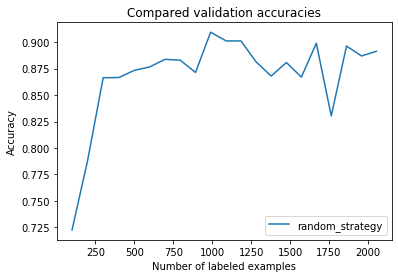

In [83]:
plt.title("Compared validation accuracies")
plt.xlabel("Number of labeled examples")
plt.ylabel("Accuracy")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,1], label=name)
plt.legend(loc='lower right')
plt.show()

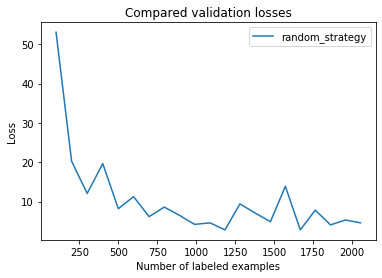

In [84]:
plt.title("Compared validation losses")
plt.xlabel("Number of labeled examples")
plt.ylabel("Loss")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,2], label=name)
plt.legend(loc='upper right')
plt.show()

The provided code only implement the "random" strategy, which chooses examples at random to label them. Your task is to compare it to other, more guided strategies. For example:

- a strategy that would label in priority the examples for which the classifier is the most uncertain, as measured by the entropy of its output
- a strategy that would label in priority the examples that appear to be near the frontier between the classes: examples for which the highest and second-highest prediction values of the classifier are close to each other.

You can also try to use other relevant decision criterion for choosing which examples to label, and implement them as new strategies. It is also possible to combine strategies together, in order to combine the strong points of each of them.

**Some advice:**

Keep in mind that your goal is to reach the best possible validation accuracy with as little labelled training examples as possible. As such, don't forget to try and change the number of initial examples for labelling, as well as the number of examples your strategy will request for labelling at each round.

Also keep in mind that you network will be trained on possibly very small datasets (think of only a few hundred of examples), while the validation set contains 5000 examples. Be careful of the risks of over-fitting, adjust your network structure and the training time (`num_iter`) appropriately.

As a baseline, you should be able to reach at least 90% of validation accuracy with less than 500 labelled examples.

**When you are done, you're asked to upload this notebook with your model, the different strategies your compared with the graphs generated by the previous code. Your strategies functions should be commented to explain what each strategy does, and which one is your best strategy.**